In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 10:29:13] [setup] RAM Tracking...
[codecarbon INFO @ 10:29:13] [setup] GPU Tracking...
[codecarbon INFO @ 10:29:13] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:29:13] [setup] CPU Tracking...
[codecarbon WARNING @ 10:29:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 10:29:16] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 10:29:16] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 10:29:16] >>> Tracker's metadata:
[codecarbon INFO @ 10:29:16]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 10:29:16]   Python version: 3.11.3
[codecarbon INFO @ 10:29:16]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 10:29:16]   Available RAM : 256.000 GB
[codecarbon INFO @ 10:29:16]   CPU count: 24
[codecarbon INFO @ 10:29:16]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb'
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [6]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


lck7bcexh4er


In [7]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [9]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [10]:
full_training_df = pd.read_csv("../../csv/highest_vs_rest_balanced_jira.csv" , index_col = 0)
full_training_df


,text_clean,label,class_original
class,,,
highest,when we do range query on simple keys it does ...,1,Highest
highest,unhandledpromiserejectionwarning unhandled pro...,1,Highest
rest,the fabricunittestdaily branch failing intermi...,0,Medium
rest,as a system operator i want to receive alerts ...,0,Medium
rest,there is no support in datasourcetransactionma...,0,Medium
...,...,...,...
rest,once i have imported a widget into the store i...,0,Low
rest,the spec defines an axiom of a ie singleton li...,0,Medium
rest,to have an history on master of all csvs setup...,0,Medium


In [11]:

# Drop NaN values and reset index of dataframe
full_training_df = full_training_df[full_training_df['text_clean'].notna()]
full_training_df = full_training_df.rename(columns={'text_clean': 'text'})
full_training_df = full_training_df.reset_index()
full_training_df.drop(columns=["class", "class_original"], inplace=True)

In [12]:
full_training_df

,text,label
0,when we do range query on simple keys it does ...,1
1,unhandledpromiserejectionwarning unhandled pro...,1
2,the fabricunittestdaily branch failing intermi...,0
3,as a system operator i want to receive alerts ...,0
4,there is no support in datasourcetransactionma...,0
...,...,...
110711,once i have imported a widget into the store i...,0
110712,the spec defines an axiom of a ie singleton li...,0
110713,to have an history on master of all csvs setup...,0
110714,there are still some changes expected to be me...,1


In [13]:
import pandas as pd
fine_tuning_df = pd.read_csv("../../csv/github_clean_mypy_testset.csv")
fine_tuning_df


,text_clean,label
0,error code misc and build errors it probably s...,1
1,no error when setter has too many arguments py...,0
2,warn about always truefalse isinstance tests t...,1
3,several crashes on pyright test suite the cras...,0
4,assert file not in selfflushedfiles without my...,1
...,...,...
729,segfault on recursive type im running mypy on ...,1
730,plugin use mypy to enrich ast with types with ...,0
731,give better error messages when calling overlo...,1
732,incompatible assignment using typeddict in gen...,0


In [14]:

fine_tuning_df = fine_tuning_df.rename(columns={'text_clean': 'text'})
fine_tuning_df

,text,label
0,error code misc and build errors it probably s...,1
1,no error when setter has too many arguments py...,0
2,warn about always truefalse isinstance tests t...,1
3,several crashes on pyright test suite the cras...,0
4,assert file not in selfflushedfiles without my...,1
...,...,...
729,segfault on recursive type im running mypy on ...,1
730,plugin use mypy to enrich ast with types with ...,0
731,give better error messages when calling overlo...,1
732,incompatible assignment using typeddict in gen...,0


In [15]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [16]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [17]:
fine_tune_train_df

,text,label
559,modules as protocols doesnt typecheck against ...,1
33,subclassing a contextmanager fails from contex...,0
275,cannot assign to field of callable type consid...,1
198,unintended consequences of eliminating promoti...,0
192,are incomplete type annotations allowed under ...,0
...,...,...
209,make columnline numbers more precise for commo...,1
568,wrong message when forstatements index variabl...,0
412,map with lambda is broken in python gives obje...,1
176,mypy doesnt understand sixwithmetaclass exampl...,1


In [18]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [19]:
df

,text,label
0,currently we are using usrshareelasticsearch a...,0
1,its been over hrs since the mirror has been up...,0
2,there has been discussion on the mailing lists...,0
3,when elytron client tries to obtain clientconf...,1
4,need to be able to release all items at once v...,1
...,...,...
94323,make columnline numbers more precise for commo...,1
94324,wrong message when forstatements index variabl...,0
94325,map with lambda is broken in python gives obje...,1
94326,mypy doesnt understand sixwithmetaclass exampl...,1


In [20]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [21]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        15949
       0        15494
1      0        15825
       1        15618
2      0        15815
       1        15627
Name: count, dtype: int64

In [22]:
df

,text,label,kfold
0,currently we are using usrshareelasticsearch a...,0,1
1,its been over hrs since the mirror has been up...,0,2
2,there has been discussion on the mailing lists...,0,1
3,when elytron client tries to obtain clientconf...,1,0
4,need to be able to release all items at once v...,1,2
...,...,...,...
94323,make columnline numbers more precise for commo...,1,2
94324,wrong message when forstatements index variabl...,0,2
94325,map with lambda is broken in python gives obje...,1,0
94326,mypy doesnt understand sixwithmetaclass exampl...,1,1


In [23]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [24]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [25]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [26]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [27]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [28]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [30]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [31]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [32]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [33]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [34]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1966/1966 [04:17<00:00,  7.62it/s, Epoch=1, LR=8.37e-6, Valid_Loss=0.607]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6790    0.5467    0.6057     15494
          HP     0.6297    0.7489    0.6842     15949

    accuracy                         0.6493     31443
   macro avg     0.6544    0.6478    0.6449     31443
weighted avg     0.6540    0.6493    0.6455     31443

Accuracy = 0.6493
F1_score = 0.6842
Validation Loss Improved (inf ---> 0.6073731552309857)
Model Saved



100%|██████████| 1966/1966 [04:17<00:00,  7.62it/s, Epoch=2, LR=4.66e-6, Valid_Loss=0.591]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6586    0.6938    0.6757     15494
          HP     0.6862    0.6506    0.6680     15949

    accuracy                         0.6719     31443
   macro avg     0.6724    0.6722    0.6718     31443
weighted avg     0.6726    0.6719    0.6718     31443

Accuracy = 0.6719
F1_score = 0.668
Validation Loss Improved (0.6073731552309857 ---> 0.5910777189999793)
Model Saved



100%|██████████| 1966/1966 [04:17<00:00,  7.62it/s, Epoch=3, LR=1.56e-6, Valid_Loss=0.586]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6940    0.7256    0.7094     15494
          HP     0.7211    0.6891    0.7047     15949

    accuracy                         0.7071     31443
   macro avg     0.7075    0.7074    0.7071     31443
weighted avg     0.7077    0.7071    0.7070     31443

Accuracy = 0.7071
F1_score = 0.7047
Validation Loss Improved (0.5910777189999793 ---> 0.5855992803803208)
Model Saved

Training complete in 1h 43m 34s
Best Loss: 0.5856


Train Loss,█▄▁
Valid Accuracy,▁▄█
Valid F1_score,▄▁█
Valid Loss,█▃▁
Best Loss,0.5856
Train Loss,0.5216
Valid Accuracy,0.7071
Valid F1_score,0.7047
Valid Loss,0.5856



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1966/1966 [04:24<00:00,  7.44it/s, Epoch=1, LR=8.37e-6, Valid_Loss=0.588]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7652    0.5285    0.6252     15825
          HP     0.6363    0.8356    0.7224     15618

    accuracy                         0.6811     31443
   macro avg     0.7007    0.6821    0.6738     31443
weighted avg     0.7011    0.6811    0.6735     31443

Accuracy = 0.6811
F1_score = 0.7224
Validation Loss Improved (inf ---> 0.5881901573001992)
Model Saved



100%|██████████| 1966/1966 [04:24<00:00,  7.44it/s, Epoch=2, LR=4.66e-6, Valid_Loss=0.565]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7117    0.6935    0.7025     15825
          HP     0.6973    0.7154    0.7062     15618

    accuracy                         0.7044     31443
   macro avg     0.7045    0.7044    0.7043     31443
weighted avg     0.7045    0.7044    0.7043     31443

Accuracy = 0.7044
F1_score = 0.7062
Validation Loss Improved (0.5881901573001992 ---> 0.5653016694332964)
Model Saved



100%|██████████| 1966/1966 [04:24<00:00,  7.43it/s, Epoch=3, LR=1.56e-6, Valid_Loss=0.566]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7198    0.6861    0.7025     15825
          HP     0.6963    0.7294    0.7125     15618

    accuracy                         0.7076     31443
   macro avg     0.7081    0.7077    0.7075     31443
weighted avg     0.7082    0.7076    0.7075     31443

Accuracy = 0.7076
F1_score = 0.7125

Training complete in 1h 43m 30s
Best Loss: 0.5653


Train Loss,█▄▁
Valid Accuracy,▁▇█
Valid F1_score,█▁▄
Valid Loss,█▁▁
Best Loss,0.5653
Train Loss,0.51366
Valid Accuracy,0.7076
Valid F1_score,0.7125
Valid Loss,0.5655



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1966/1966 [04:17<00:00,  7.64it/s, Epoch=1, LR=8.37e-6, Valid_Loss=0.578]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7389    0.6002    0.6624     15815
          HP     0.6600    0.7854    0.7172     15627

    accuracy                         0.6922     31442
   macro avg     0.6994    0.6928    0.6898     31442
weighted avg     0.6997    0.6922    0.6896     31442

Accuracy = 0.6922
F1_score = 0.7172
Validation Loss Improved (inf ---> 0.5776379474375162)
Model Saved



100%|██████████| 1966/1966 [04:17<00:00,  7.64it/s, Epoch=2, LR=4.66e-6, Valid_Loss=0.561]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7029    0.7196    0.7111     15815
          HP     0.7092    0.6921    0.7006     15627

    accuracy                         0.7059     31442
   macro avg     0.7060    0.7059    0.7058     31442
weighted avg     0.7060    0.7059    0.7059     31442

Accuracy = 0.7059
F1_score = 0.7006
Validation Loss Improved (0.5776379474375162 ---> 0.5608460582870008)
Model Saved



100%|██████████| 1966/1966 [04:17<00:00,  7.63it/s, Epoch=3, LR=1.56e-6, Valid_Loss=0.563]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7246    0.6935    0.7087     15815
          HP     0.7027    0.7332    0.7176     15627

    accuracy                         0.7132     31442
   macro avg     0.7136    0.7133    0.7131     31442
weighted avg     0.7137    0.7132    0.7131     31442

Accuracy = 0.7132
F1_score = 0.7176

Training complete in 1h 44m 11s
Best Loss: 0.5608


Train Loss,█▄▁
Valid Accuracy,▁▆█
Valid F1_score,█▁█
Valid Loss,█▁▂
Best Loss,0.56085
Train Loss,0.51711
Valid Accuracy,0.7132
Valid F1_score,0.7176
Valid Loss,0.56312


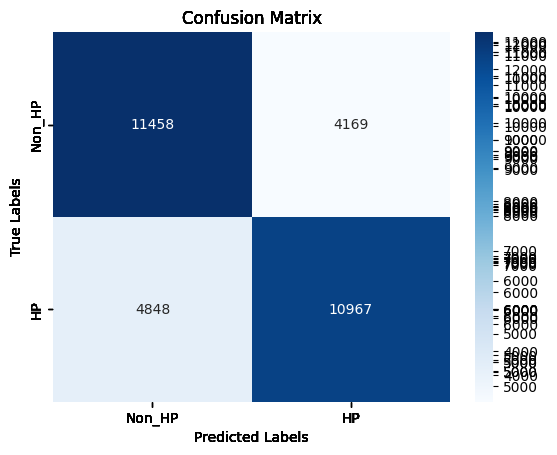

In [35]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [36]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [37]:
test_df = fine_tune_test_df

In [38]:
test_df

,text,label
264,self doesnt work when appears in a callable di...,0
536,strictequality should be more flexible current...,0
259,incorrect type inferred for dictiterable this ...,0
137,crash on master branch when using customtypesh...,1
227,new semantic analyzer crash on cyce in inherit...,1
...,...,...
71,tuple used as immutable sequence is considered...,1
106,incorrect assuming class property is a method ...,0
270,allow disabling implicit any for type aliases ...,0
435,literal type not accepted as key when construc...,1


In [39]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [40]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [41]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [42]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [43]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [44]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 33/33 [00:05<00:00,  5.65it/s]


Fold 1


100%|██████████| 33/33 [00:05<00:00,  6.05it/s]


Fold 2


100%|██████████| 33/33 [00:05<00:00,  6.04it/s]


In [45]:
deberta_predictions


[array([[0.76993865, 0.23006138],
        [0.866936  , 0.13306405],
        [0.5231336 , 0.47686642],
        ...,
        [0.8291652 , 0.17083476],
        [0.78468835, 0.21531168],
        [0.9055498 , 0.09445017]], dtype=float32),
 array([[0.74207664, 0.2579233 ],
        [0.8993734 , 0.10062658],
        [0.6239178 , 0.3760822 ],
        ...,
        [0.84298104, 0.15701899],
        [0.7422861 , 0.25771382],
        [0.8179553 , 0.18204463]], dtype=float32),
 array([[0.66096175, 0.33903825],
        [0.9047623 , 0.09523762],
        [0.6089975 , 0.39100257],
        ...,
        [0.7704104 , 0.22958957],
        [0.57101667, 0.4289834 ],
        [0.7678826 , 0.23211741]], dtype=float32)]

In [46]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.72432566, 0.2756743 ],
       [0.89035726, 0.10964274],
       [0.5853496 , 0.4146504 ],
       ...,
       [0.8141856 , 0.18581444],
       [0.69933033, 0.30066964],
       [0.83046263, 0.16953741]], dtype=float32)

In [47]:
len(predictions)

514

In [48]:
predictions

array([[0.72432566, 0.2756743 ],
       [0.89035726, 0.10964274],
       [0.5853496 , 0.4146504 ],
       ...,
       [0.8141856 , 0.18581444],
       [0.69933033, 0.30066964],
       [0.83046263, 0.16953741]], dtype=float32)

In [49]:
test_df["prediction_0"] = predictions[:, 0] 

In [50]:
test_df["prediction_1"] = predictions[:, 1] 

In [51]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [52]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
264,self doesnt work when appears in a callable di...,0,0.724326,0.275674,0,0,0
536,strictequality should be more flexible current...,0,0.890357,0.109643,0,0,0
259,incorrect type inferred for dictiterable this ...,0,0.585350,0.414650,0,0,0
137,crash on master branch when using customtypesh...,1,0.119847,0.880153,1,1,1
227,new semantic analyzer crash on cyce in inherit...,1,0.100066,0.899934,1,1,1
...,...,...,...,...,...,...,...
71,tuple used as immutable sequence is considered...,1,0.887251,0.112749,0,0,0
106,incorrect assuming class property is a method ...,0,0.754398,0.245602,0,0,0
270,allow disabling implicit any for type aliases ...,0,0.814186,0.185814,0,0,0
435,literal type not accepted as key when construc...,1,0.699330,0.300670,0,0,0


In [53]:
len(test_df)

514

In [54]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [55]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [56]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [57]:
test_df["pred"] = test_df["pred"].astype(int)

In [58]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
264,self doesnt work when appears in a callable di...,0,0.724326,0.275674,0,0,0,prediction_0,0
536,strictequality should be more flexible current...,0,0.890357,0.109643,0,0,0,prediction_0,0
259,incorrect type inferred for dictiterable this ...,0,0.585350,0.414650,0,0,0,prediction_0,0
137,crash on master branch when using customtypesh...,1,0.119847,0.880153,1,1,1,prediction_1,1
227,new semantic analyzer crash on cyce in inherit...,1,0.100066,0.899934,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
71,tuple used as immutable sequence is considered...,1,0.887251,0.112749,0,0,0,prediction_0,0
106,incorrect assuming class property is a method ...,0,0.754398,0.245602,0,0,0,prediction_0,0
270,allow disabling implicit any for type aliases ...,0,0.814186,0.185814,0,0,0,prediction_0,0
435,literal type not accepted as key when construc...,1,0.699330,0.300670,0,0,0,prediction_0,0


In [59]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[223  34]
 [146 111]]


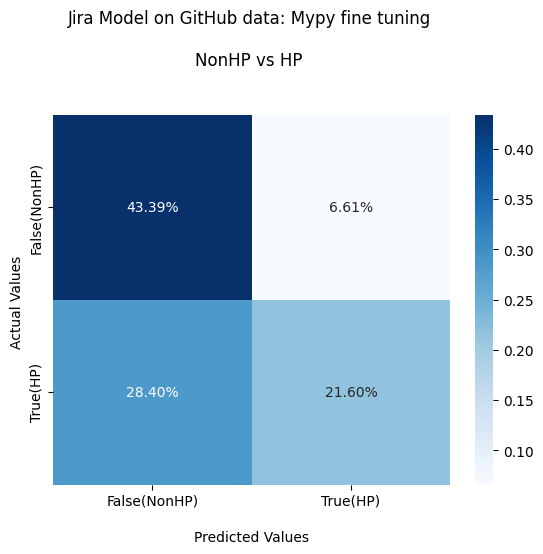

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Jira Model on GitHub data: Mypy fine tuning \n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [61]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71       257
           1       0.77      0.43      0.55       257

    accuracy                           0.65       514
   macro avg       0.68      0.65      0.63       514
weighted avg       0.68      0.65      0.63       514



In [62]:
test_df[["text","label","pred"]].to_csv("Flutter_70_Test_inference.csv")

In [63]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.3328844749128108


In [64]:
tracker.stop()

0.04803157196325461